# Running route generation

In [2]:
import osmnx as ox
from osmnx._errors import InsufficientResponseError
import pandas as pd
import numpy as np
import geopandas as gpd

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import math
import statistics
from collections import defaultdict, deque
import random
import heapq
from shapely.geometry import Point

ox.__version__

'2.0.3'

In [3]:
# Configure which tags should be added as graph edge or node attributes
ox.settings.useful_tags_node = ["highway", "junction", "railway", "ref"]
ox.settings.useful_tags_way = ["access", "area", "bridge", "est_width", "highway", "junction", "landuse", "oneway", "ref", "service", "width", "lit", "surface"]

## Retreive graph

In [11]:
#Retrives the graph around the start point in a route length / 2 radius
def retrieve_graph(start_point, route_length):
    
    
    try:
        # Retrieve all types of roads/pathways within the radius of route length / 2 from the start in the form of a graph
        G = ox.graph.graph_from_point(center_point=start_point, dist=route_length/2, dist_type="network", network_type="all", simplify=True)

        # When using a simplified graph the edges that are straight lines get no geometry attribute
        # Making sure all edges include geometry attribute. Create GeoDataFrames for nodes and edges, with geometry attribute filled in for all edges
        nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)
        # then re-create a graph from those GeoDataFrames
        G = ox.graph_from_gdfs(nodes, edges, graph_attrs=G.graph)

        # Make sure all edges actually have geometry data
        for u, v, data in G.edges(keys=False, data=True):
            assert "geometry" in data

        return G
    except ValueError:
        # Return empty graph
        return nx.MultiDiGraph()

## Features / preferences
This section retrieves graph data for features / preferences

#### Elevation

In [12]:
# Adds corresponding elevation data to all nodes in a graph. Using this, it calculates the edge grade and rise for all edges
def add_elevation(graph):
    # Assign elevation to all nodes using data from Open Topo Data, then calculate the edge grades
    original_elevation_url = ox.settings.elevation_url_template
    ox.settings.elevation_url_template = (
        "https://api.opentopodata.org/v1/aster30m?locations={locations}"
    )
    graph = ox.elevation.add_node_elevations_google(graph, batch_size=100, pause=1)
    graph = ox.elevation.add_edge_grades(graph)
    ox.settings.elevation_url_template = original_elevation_url

    for edge in graph.edges:
        graph.edges[edge]["rise"] = graph.edges[edge]["grade"] * graph.edges[edge]["length"]

    return graph

In [13]:
def assign_elevation_tags(graph):
    # Get a list including all the absolute edge grades
    grades = [
        data["grade_abs"]
        for _, _, data in graph.edges(data=True)
        if "grade_abs" in data
    ]

    # Calculate the 33rd and 66th percentiles
    p33 = np.percentile(grades, 33)
    p66 = np.percentile(grades, 66)

    # Assign elevation tags
    for edge in graph.edges:
        edge_grade = graph.edges[edge]["grade_abs"]
        if edge_grade <= p33:
            graph.edges[edge]["elev_tag"] = "Flat"
        elif edge_grade <= p66:
            graph.edges[edge]["elev_tag"] = "Moderate"
        else:
            graph.edges[edge]["elev_tag"] = "Hilly"

    return graph

#### POI

In [14]:
# Return the X and Y values of a series of features. For lines and polygons the coordinates of the centroid is returned
def get_feature_coordinates(features):
    return features.geometry.centroid.x, features.geometry.centroid.y

In [15]:
# Tags the closest edge to each viewpoint POI as a viewpoint edge
def assign_viewpoint_edges(G, start_point, route_length):

    tags = {"tourism": "viewpoint"}


    # Find POI features
    try:
        viewpoint_features = ox.features.features_from_point(start_point, tags, route_length/2)
    except InsufficientResponseError:
        viewpoint_features = None
    
    if viewpoint_features is not None and not viewpoint_features.empty:
        # Project graph to UTM, to be able to measure distance in meters
        G_proj = ox.project_graph(G)

        # Project the viewpoint features to the same CRS as the graph
        viewpoint_features_proj = viewpoint_features.to_crs(G_proj.graph['crs'])

        # Connect the viewpoint to their closest edge
        viewpoint_features_proj_x, viewpoint_features_proj_y = get_feature_coordinates(viewpoint_features_proj)
        viewpoint_edges = ox.distance.nearest_edges(G_proj, viewpoint_features_proj_x, viewpoint_features_proj_y)

        for edge in viewpoint_edges:
            G.edges[edge]["Viewpoint"] = True

    return G

In [16]:
# Tags the closest edge to each tourism POI as a tourism edge
def assign_tourism_edges(G, start_point, route_length):

    tags = {"toursim": "artwork", "memorial": "statue", "tourism": "attraction"}


    # Find POI features
    try:
        tourism_features = ox.features.features_from_point(start_point, tags, route_length/2)
    except InsufficientResponseError:
        tourism_features = None

    if tourism_features is not None and not tourism_features.empty:
        # Project graph to UTM, to be able to measure distance in meters
        G_proj = ox.project_graph(G)
        
        # Project the tourism features to the same CRS as the graph
        tourism_features_proj = tourism_features.to_crs(G_proj.graph['crs'])

        # Connect the viewpoint to their closest edge
        tourism_features_proj_x, tourism_features_proj_y = get_feature_coordinates(tourism_features_proj)
        tourism_edges = ox.distance.nearest_edges(G_proj, tourism_features_proj_x, tourism_features_proj_y)

        for edge in tourism_edges:
            G.edges[edge]["Tourism"] = True

    return G

### Nature

In [17]:
# Tags all edges that are within 15 of park, wood or farmland as a nature edge
def assign_nature_edges(G, start_point, route_length):

    nature_feature_tags = {"leisure": "park", "natural": "wood", "landuse": "farmland"}

    # Add nature data to edges
    try:
        nat_features = ox.features.features_from_point(start_point, nature_feature_tags, route_length/2)
    except InsufficientResponseError:
        nat_features = None

    if nat_features is not None and not nat_features.empty:

        # Project graph to UTM, to be able to measure distance in meters
        G_proj = ox.project_graph(G)
    
        # Project the nature features to the same CRS as the graph
        nat_features_proj = nat_features.to_crs(G_proj.graph['crs'])

        # Create a buffer of 15m around the nature features
        buffer_distance = 15
        buffered_nature = nat_features_proj.buffer(buffer_distance)
        buffered_union = gpd.GeoSeries(buffered_nature).union_all()

        # Mark edges as near nature if they intersect the buffered union
        for u, v, k, data in G_proj.edges(keys=True, data=True):
            edge = (u, v, k)
            geom = data.get("geometry")
            if geom is not None and geom.intersects(buffered_union):
                G.edges[edge]["Nature"] = True
            else:
                G.edges[edge]["Nature"] = False

    return G

### Lighting

In [18]:
# lighting is already available via G.edges[edge]["lit"] = "yes"

### Surface

In [19]:
# Tag edges as either trail or road based on surface types of edge
def assign_surface_types(G):
    trail_surfaces ={"fine_gravel", "gravel", "ground", "dirt", "grass"}
    trail_highways = {"path", "track"}

    for u, v, k, data in G.edges(keys=True, data=True):
        edge_type = data.get("highway")
        surface = data.get("surface")

        # Handle cases where edge_type and/or surface are lists
        if isinstance(edge_type, list):
            type_match = any(t in trail_highways for t in edge_type)
        else:
            type_match = edge_type in trail_highways

        if isinstance(surface, list):
            surface_match = any(s in trail_surfaces for s in surface)
        else:
            surface_match = surface in trail_surfaces

        if type_match or surface_match:
            G.edges[u, v, k]["Trail"] = True
        else:
            G.edges[u, v, k]["Road"] = True

    return G

## Assign edge weights
This section assigns weights to edges based on preferences and attributes of the edges. The weighting is done differently for the approximation algorithms and the heuristic algorithm

In [51]:
# Retrives feature data for the specified features in features_wanted (same size as in preference vector)
def retrieve_relevant_feature_data(G, pref, start_point, route_length, features_wanted):
    
    if features_wanted[0] == 1 or features_wanted[1] == 1:
        G = add_elevation(G)
        G = assign_elevation_tags(G)

    if features_wanted[2] == 1 or features_wanted[3] == 1:
        G = assign_surface_types(G)
    if features_wanted[4] == 1:
        G = assign_nature_edges(G, start_point, route_length)
    if features_wanted[6] == 1:
        G = assign_tourism_edges(G, start_point, route_length)
    if features_wanted[7] == 1:
        G = assign_viewpoint_edges(G, start_point, route_length)
    
    return G

In [20]:
def calculate_attribute_values_approx_alg(edge_data):
    attribute_values = 8 * [0]

    # Flat and hilly attribute value
    match edge_data.get("elev_tag"):
        case "Flat":
            attribute_values[0] = 2
            attribute_values[1] = 0.5
        case "Moderate":
            attribute_values[0] = 1
            attribute_values[1] = 1
        case "Hilly":
            attribute_values[0] = 0.5
            attribute_values[1] = 2
    
    # Road, trail, nature and lighting attribute values
    if edge_data.get("Road") == True:
        attribute_values[2] = 2
    else:
        attribute_values[3] = 2

    if edge_data.get("Nature") == True:
        attribute_values[4] = 2

    if edge_data.get("lit") == "yes":
        attribute_values[5] = 2
    
    # POI attribute values
    if edge_data.get("Tourism") == True:
        attribute_values[6] = 2
    if edge_data.get("Viewpoint") == True:
        attribute_values[7] = 2

    return attribute_values

In [21]:
def assign_weights_approx_alg(G, pref):
    for u, v, k, data in G.edges(keys=True, data=True):
        edge = (u, v, k)
        attribute_values = calculate_attribute_values_approx_alg(data)
        the_sum = sum(a * b for a, b in zip(pref, attribute_values))
        G.edges[edge]["weight_approx_alg"] = data["length"] * max(1, the_sum)
        #G.edges[edge]["weight_approx_alg"] = data["length"] * (the_sum+1)
        
    return G

#### Heuristic

In [22]:
def calculate_attribute_values_heuristic(edge_data):
    attribute_values = 8 * [1]

    # Flat and hilly attribute value
    match edge_data.get("elev_tag"):
        case "Flat":
            attribute_values[0] = 0.7
            attribute_values[1] = 1.3
        case "Moderate":
            attribute_values[0] = 1
            attribute_values[1] = 1
        case "Hilly":
            attribute_values[1] = 1.3
            attribute_values[1] = 0.7
    
    # Road, trail, nature and lighting attribute values
    if edge_data.get("Road") == True:
        attribute_values[2] = 0.7
    else:
        attribute_values[3] = 0.7

    if edge_data.get("Nature") == True:
        attribute_values[4] = 0.7

    if edge_data.get("lit") == "yes":
        attribute_values[5] = 0.7

    return attribute_values

In [23]:
def assign_weights_heuristic(G, pref):
    for u, v, k, data in G.edges(keys=True, data=True):
        edge = (u, v, k)
        attribute_values = calculate_attribute_values_heuristic(data)
        G.edges[edge]["weight_heuristic"] = data["length"] * math.prod(a ** b for a, b in zip(attribute_values, pref))
        
    return G

## Routing
Here follows implementations of the three algorithms. In order for the greedy and DP-algorithm to work, we need edge lengths of whole numbers. So all edge lengths are rounded at the start.

In [24]:
def round_edge_lengths(graph):
    for u, v, key, data in graph.edges(keys=True, data=True):
        original = data.get("length", 1)
        rounded = max(1, round(original))
        data["length"] = rounded
    return graph

### Greedy algorithm

In [25]:
def greedy(G, start, k):
    # Calculate shortest path from every vertex to s using Dijkstra on reverse of graph
    SPD = nx.single_source_dijkstra_path_length(G.reverse(copy=True), source=start, weight="length")

    walk = [start]
    L = 0
    u = start
    Rep = defaultdict(int)  # repetition count of edges (u,v)

    for _ in range(2*G.number_of_edges()):
        candidates = []
        L_current = L + SPD[u]

        for n in G.neighbors(u):
            # Make sure it does not go back to start for as long as possible
            if start == n:
                continue
            
            if n not in SPD:
                continue
            L_possible = L + G[u][n][0].get("length") + SPD[n]
            if abs(k - L_possible) <= abs(k - L_current):
                candidates.append(n)

        if not candidates:
            break

        min_rep_nodes = [c for c in candidates if Rep[(u, c)] == min(Rep[(u, c)] for c in candidates)]

        c = max(min_rep_nodes, key=lambda c: G[u][c][0].get("weight_approx_alg"))
        Rep[(u, c)] += 1
        Rep[(c, u)] += 1
        walk.append(c)
        L += G[u][c][0].get("length")
        u = c
    
    if u != start:
        # append closest walk 
        shortest_path = nx.shortest_path(G, u, start, weight='length')
        shortest_path.pop(0)
        walk.extend(shortest_path)

    return walk

### Dynamic programming

In [26]:
def dynamic_programming(graph, start, k, pref):
    L_max = 2 * k
    nodes = list(graph.nodes)
    
    # Initialize DP-matrix
    DP = defaultdict(lambda: defaultdict(lambda: -math.inf))
    DP[start][0] = 0

    # Initialize recent edge history
    recent = defaultdict(list)
    prev = defaultdict(dict)
    poi_count = defaultdict(int)

    repeat_penalty = 2
    max_history = 20

    for ell in range(L_max + 1):
        for u in nodes:
            if DP[u][ell] == -math.inf:
                continue
            for v in graph.successors(u):
                for key in graph[u][v]:  # To handle MultiDiGraph
                    if u == start and ell > 0:
                        continue

                    edge_data = graph[u][v][key]
                    edge_len = edge_data.get("length_scaled")
                    edge_weight = edge_data.get("weight_approx_alg", 1)

                    ell_prime = ell + edge_len
                    if ell_prime > L_max:
                        continue

                    # Handle POI
                    if pref[6] == 1 or pref[7] == 0:
                        adjusting_factor = min(2, 1 + 0.1*poi_count[(u, ell)])
                        edge_weight *= adjusting_factor
                    
                    # Handle repetiton
                    #edge = (u, v)
                    #if edge in recent[(u, ell)] or (v, u) in recent[(u, ell)]:
                    #    edge_weight = min(-repeat_penalty*edge_weight, repeat_penalty*edge_weight)
                    edge = (u, v)
                    if edge in recent[(u, ell)] or (v, u) in recent[(u, ell)]:
                        new_weight = DP[u][ell] - repeat_penalty*edge_weight
                    else:
                        new_weight = DP[u][ell] + edge_weight
                    
                    #new_weight = DP[u][ell] + edge_weight

                    if new_weight > DP[v][ell_prime]:
                        DP[v][ell_prime] = new_weight
                        saved_recent = recent[(u, ell)][-(max_history - 1):]
                        recent[(v, ell_prime)] = saved_recent + [edge]
                        prev[v][ell_prime] = (u, ell)

                        if edge_data.get("Toursim") == True or edge_data.get("Viewpoint") == True:
                            poi_count[(v, ell_prime)] = poi_count[(u, ell)] + 1
    
    # Find best endpoint at s with minimal deviation from k
    best_ell = None
    min_deviation = math.inf
    for ell in DP[start]:
        if DP[start][ell] != -math.inf:
            deviation = abs(ell - k)
            if deviation < min_deviation:
                best_ell = ell
                min_deviation = deviation

    # Backtrack to recover walk
    walk_nodes = deque()
    current = (start, best_ell)
    walk_nodes.appendleft(current[0])  # Start node

    while current[1] in prev.get(current[0], {}):
        u, ell = prev[current[0]][current[1]]
        walk_nodes.appendleft(u)
        current = (u, ell)

    return list(walk_nodes)

In [27]:
# Dynamic prograaming approximation scheme
def dp_approximation_scheme(G, start, k, pref, epsilon):
    delta = epsilon * k / G.number_of_edges()

    for edge in G.edges:
        G.edges[edge]["length_scaled"] = math.ceil(G.edges[edge]["length"] / delta) 

    k_prime = math.ceil(k / delta)
    print(k_prime)
    return dynamic_programming(G, start, k_prime, pref)

### Heuristic

In [31]:
# Combines 3 routes into 1 for the heuristic
def combine_routes(route1, route2, route3):
    route1.pop()
    route2.pop()
    return route1 + route2 + route3 

In [32]:
# Returns isochrone nodes of radius +- 10% around the center node
def get_isochrone_nodes(graph, center_node, radius):
    outer_subgraph = nx.ego_graph(graph, center_node, radius=radius*1.1, distance="length")
    inner_subgraph = nx.ego_graph(graph, center_node, radius=radius*0.9, distance="length")

    return outer_subgraph.nodes - inner_subgraph.nodes

In [33]:
# Find set of random pairs of via-vertices
def find_random_pairs_of_via_vertices(G, start_vertex, route_length):
    isochrone = get_isochrone_nodes(G, start_vertex, route_length/3)

    valid_pairs_of_via_vertices = list()
    
    random.seed(42)
    random_via_vertices = random.sample(list(isochrone), min(10, len(list(isochrone))))
  
    for vv1 in random_via_vertices:
        isochrone2 = get_isochrone_nodes(G, vv1, route_length/3)
        for vv2 in isochrone2:
            if vv2 in isochrone and vv2 != start_vertex:
                valid_pairs_of_via_vertices.append((vv1, vv2))
                break

    return valid_pairs_of_via_vertices

In [34]:
# Shortest path between vertices that takes POIs into account
def shortest_path_poi(G, vertex1, vertex2, poi_tags):
    heap = [(0, vertex1, [], 0)]  # (distance, node, path, poi_count)
    best = {}  # best distance to each node

    shortest_to_target = float("inf")
    best_path = None

    while heap:
        dist_u, u, path, poi_count = heapq.heappop(heap)
        path = path + [u]

        # Check if we already have found a better path to this node
        if u in best and best[u] <= dist_u:
            continue
        best[u] = dist_u

        # Update target info if we reach it
        if u == vertex2:
            if dist_u < shortest_to_target:
                shortest_to_target = dist_u
                best_path = path
            continue  # Don't return yet — there could be a better path

        for v in G.neighbors(u):
            for key, data in G[u][v].items():
                weight = data.get("weight_heuristic", 0)
                # Adjust weight based on poi_count
                adjusting_factor = max(0.1, 0.5-0.1*poi_count)
                weight *= adjusting_factor
                
                is_poi = False
                if "Tourism" in poi_tags:
                    is_poi = data.get("tourism", False)
                if "Viewpoint" in poi_tags and not is_poi:
                    is_poi = data.get("viewpoint", False)

                new_poi_count = poi_count + 1 if is_poi else poi_count
                heapq.heappush(heap, (dist_u + weight, v, path, new_poi_count))

    return best_path  # Will be None if no path was found

In [35]:
# Generates a route for the heuristic algorithm based on start node and a pair of via-vertices
def generate_route(G, start, viavertex1, viavertex2, pref):
    
    poi_tags = []
    
    if pref[6] == 1:
        poi_tags.append("Tourism")
    if pref[7] == 1:
        poi_tags.append("Viewpoint")
        
    if poi_tags:
        route1 = shortest_path_poi(G, start, viavertex1, poi_tags)
        route2 = shortest_path_poi(G, viavertex1, viavertex2, poi_tags)
        route3 = shortest_path_poi(G, viavertex2, start, poi_tags)
    else:
        try:
            route1 = nx.shortest_path(G, source=start, target=viavertex1, weight="weight_heuristic")
            route2 = nx.shortest_path(G, source=viavertex1, target=viavertex2, weight="weight_heuristic")
            route3 = nx.shortest_path(G, source=viavertex2, target=start, weight="weight_heuristic")
        except NetworkXNoPath:
            return [start]
    
    return combine_routes(route1, route2, route3)

In [36]:
# Calculates the weight of a route from the heuristic algorithm
def weight_of_route(route_gdf):
    total_weight = 0
    for edge, edge_info in route_gdf.iterrows():
        total_weight += edge_info.get("weight_heuristic")
    return total_weight
    

In [37]:
def heuristic(G, start_vertex, route_length, pref):

    possible_via_vertices = find_random_pairs_of_via_vertices(G, start_vertex, route_length)
    best_route = [start_vertex]
    best_route_weight = math.inf
    
    for i, pair_of_via_vertices in enumerate(possible_via_vertices):
        route = generate_route(G, start_vertex, pair_of_via_vertices[0], pair_of_via_vertices[1], pref)
        weight = weight_of_route(ox.routing.route_to_gdf(G, route, weight="weight_heuristic"))
        if weight < best_route_weight:
            best_route = route
            best_route_weight = weight
    
    return best_route

## Statistics about route


In [46]:
# Function that returns all necessary statistics for a route
def get_stats_of_route(route_length, route_gdf):

    total_length = 0
    
    length_of_repetition = 0
    visited_edges = set()

    total_elevation = 0

    length_of_road = 0
    length_of_trail = 0
    length_of_nature = 0
    length_of_lighting = 0
    
    number_of_viewpoints = 0
    number_of_tourism = 0

    for edge, edge_info in route_gdf.iterrows():
        # Update total length
        edge_length = edge_info.get("length")
        total_length += edge_length

        # Update repetition
        u, v, _ = edge
        if (u,v) in visited_edges or (v,u) in visited_edges:
            length_of_repetition += edge_length
        else:
            visited_edges.add((u,v))

        # Update elevation
        if edge_info.get("rise") and edge_info.get("rise") > 0:
            total_elevation += edge_info.get("rise")

        # Update surface
        if edge_info.get("Road") == True:
            length_of_road += edge_length
        elif edge_info.get("Trail") == True:
            length_of_trail += edge_length
            
        # Update nature
        if edge_info.get("Nature") == True:
            length_of_nature += edge_length

        # Update lighting
        if edge_info.get("lit") == "yes":
            length_of_lighting += edge_length


        # Update POI
        if (edge_info.get("Viewpoint") == True) and not ((u,v) in visited_edges or (v,u) in visited_edges):
            number_of_viewpoints += 1

        if (edge_info.get("Tourism") == True) and not ((u,v) in visited_edges or (v,u) in visited_edges):
            number_of_tourism += 1

    statistics = dict()
    
    statistics["length"] = total_length

    statistics["length_deviation"] = abs(total_length - route_length)
    
    if total_length > 0:
        statistics["repetition"] = length_of_repetition / total_length
        statistics["road"] = length_of_road / total_length
        statistics["trail"] = length_of_trail / total_length
        statistics["nature"] = length_of_nature / total_length
        statistics["lighting"] = length_of_lighting / total_length
    else:
        statistics["repetition"] = 0
        statistics["road"] = 0
        statistics["trail"] = 0
        statistics["nature"] = 0
        statistics["lighting"] = 0       
        
    statistics["elevation"] = total_elevation

    statistics["viewpoint"] = number_of_viewpoints
    statistics["tourism"] = number_of_tourism

    return statistics

# Experiments

In [47]:
# Coordinates of the starting points for the datasets

dataset_1_lat = 57.702582
dataset_1_long = 11.964342

dataset_2_lat = 59.435529 
dataset_2_long = 17.952240

dataset_3_lat = 61.119136
dataset_3_long = 14.620491

dataset_4_lat = 55.383511
dataset_4_long = 14.063187

In [48]:
# Prepares the graph for a route starting in a location with a specific route length
def prepare_graph(lat, long, route_length, pref, features_wanted):
    start_point = lat, long

    # Retrieve graph and relevant feature data
    G = retrieve_graph(start_point, route_length)
    
    if G.number_of_nodes() != 0:
        G = retrieve_relevant_feature_data(G, pref, start_point, route_length, features_wanted)

        # Assign edge weights based on preferences and feature data
        G = assign_weights_approx_alg(G, pref)
        G = assign_weights_heuristic(G, pref)

        # Round the length of edges 
        G = round_edge_lengths(G)
    
    return G

In [50]:
# Testing how many edges are in the graphs
pref = [0,0,0,0,0,0,0,0]
k = 5000
G1 = prepare_graph(dataset_1_lat, dataset_1_long, k, pref, pref)
G2 = prepare_graph(dataset_2_lat, dataset_2_long, k, pref, pref)
G3 = prepare_graph(dataset_3_lat, dataset_3_long, k, pref, pref)
G4 = prepare_graph(dataset_4_lat, dataset_4_long, k, pref, pref)
print("Dataset 1: " + str(G1.number_of_edges()))
print("Dataset 2: " + str(G2.number_of_edges()))
print("Dataset 3: " + str(G3.number_of_edges()))
print("Dataset 4: " + str(G4.number_of_edges()))

NameError: name 'retrieve_relevant_feature_data' is not defined

In [ ]:
k=1000
epsilon = 500
G1 = 34300
G2 = 11902
G3 = 2303
G4 = 345
epsilon1 = 100
epsilon2 = G2/(k/2)
epsilon3 = G3/(k/2)
epsilon4 = G4/(k/2)

#delta = (epsilon * k) / G1

#k_prime = math.ceil(k / delta)
#print(math.ceil(20 / delta))

print("Dataset 1 k: " + str(math.ceil(k / ((epsilon * k) / G1))))
print("Dataset 2 k: " + str(math.ceil(k / ((epsilon * k) / G2))))
print("Dataset 3 k: " + str(math.ceil(k / ((epsilon * k) / G3))))
print("Dataset 4 k: " + str(math.ceil(k / ((epsilon * k) / G4))))

100
500
200
500
300
500
400
500
500
500
600
500
700
501
800
500
900
500
1000
500
100
500
200
500
300
500
400
500
500
500
600
500
700
500
800
500
900
500
1000
500
100
500
200
500
300
500
400
500
500
500
600
500
700
500
800
500
900
500
1000
500
100
500
200
501
300
500
400
501
500
500
600
500
700
500
800
501
900
501
1000
500


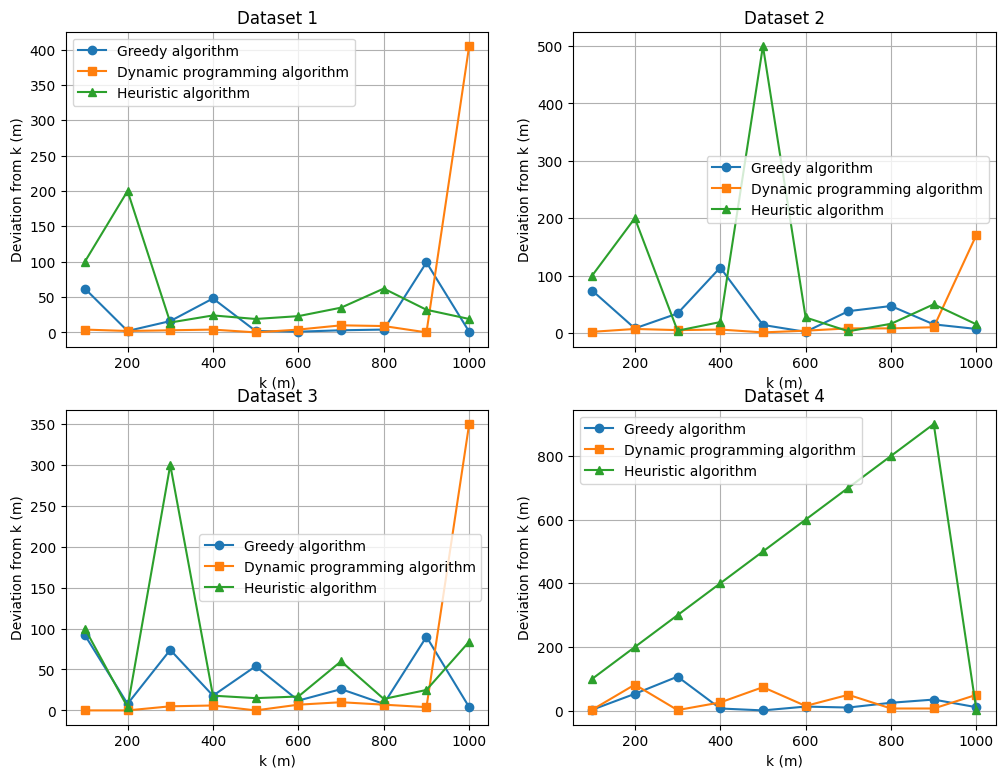

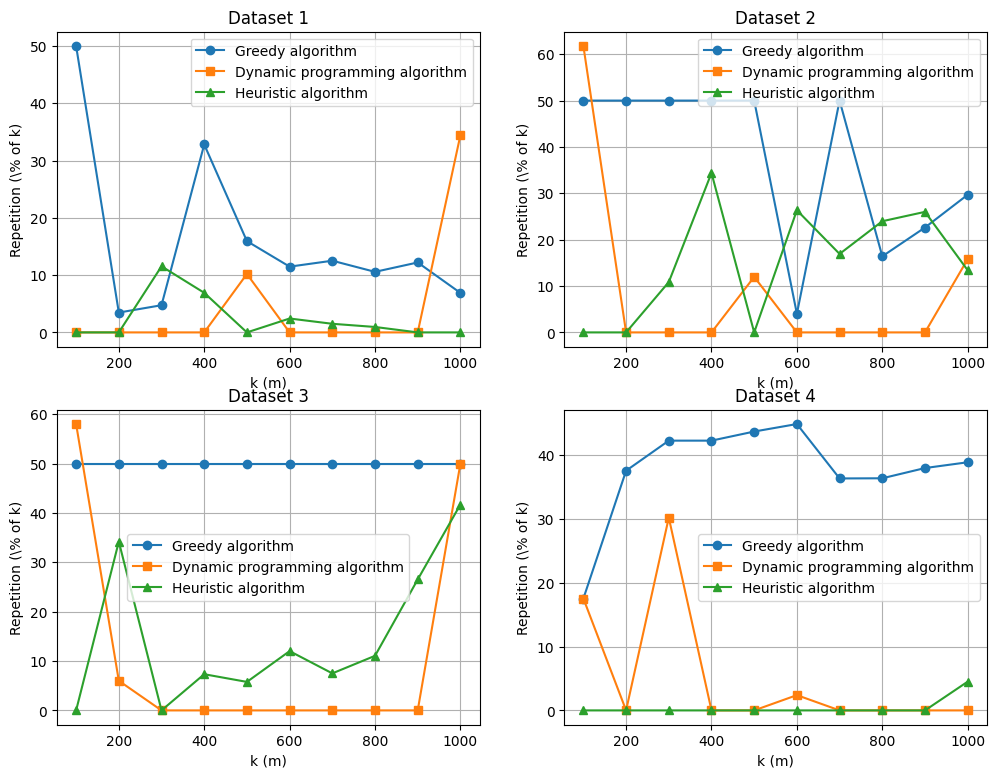

In [154]:
# Generate deviation and repetition diagram
def dev_and_rep_diagram(lat, long, fig_dev, fig_rep, axs_dev, axs_rep, dataset_num):
    
    longest_k = 1000
    pref = [0,0,0,0,0,0,0,0]
    
    G = prepare_graph(lat, long, longest_k, pref, pref)
    
    start_vertex = ox.nearest_nodes(G, long, lat)
    
    k_values = []

    # Store value of deviation for the three algorithms
    greedy_values = []
    dp_values = []
    heuristic_values = []
    
    # Store repetition of the three algorithms
    greedy_rep = []
    dp_rep = []
    heuristic_rep = []
    
    for k in range(100, longest_k+1, 100):
        print(k)
        
        if k > 0:
            greedy_route = greedy(G, start_vertex, k)
            #dp_route = dp_approximation_scheme(G, start_vertex, k, pref, 100)
            # Test av epsilon
            dp_route = dp_approximation_scheme(G, start_vertex, k, pref, G.number_of_edges() / 500)
            heuristic_route = heuristic(G, start_vertex, k, pref)
        else:
            greedy_route = [start_vertex]
            dp_route = [start_vertex]
            heuristic_route = [start_vertex]
        
        if len(greedy_route) == 1 or len(dp_route) == 1 or len(heuristic_route) == 1:
            G.add_edge(start_vertex, start_vertex, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)
            
        greedy_stats = get_stats_of_route(k, ox.routing.route_to_gdf(G, greedy_route, weight="weight_approx_alg"))
        dp_stats = get_stats_of_route(k, ox.routing.route_to_gdf(G, dp_route, weight="weight_approx_alg"))
        heuristic_stats = get_stats_of_route(k, ox.routing.route_to_gdf(G, heuristic_route, weight="weight_heuristic"))
        
        
        k_values.append(k)
        greedy_values.append(greedy_stats["length_deviation"])
        dp_values.append(dp_stats["length_deviation"])
        heuristic_values.append(heuristic_stats["length_deviation"])
        
        greedy_rep.append(greedy_stats["repetition"]*100)
        dp_rep.append(dp_stats["repetition"]*100)
        heuristic_rep.append(heuristic_stats["repetition"]*100)
    
    # Plot deviation
    plt.figure(fig_dev.number)
    plt.sca(axs_dev) # Select subplot
    plt.plot(k_values, greedy_values, label='Greedy algorithm', marker='o')
    plt.plot(k_values, dp_values, label='Dynamic programming algorithm', marker='s')
    plt.plot(k_values, heuristic_values, label='Heuristic algorithm', marker='^')
    plt.xlabel('k (m)')
    plt.ylabel('Deviation from k (m)')
    axs_dev.set_title("Dataset " + str(dataset_num))
    plt.legend()
    plt.grid(True)
    
    # Plot repetition
    plt.figure(fig_rep.number)
    plt.sca(axs_rep) # Select subplot
    plt.plot(k_values, greedy_rep, label='Greedy algorithm', marker='o')
    plt.plot(k_values, dp_rep, label='Dynamic programming algorithm', marker='s')
    plt.plot(k_values, heuristic_rep, label='Heuristic algorithm', marker='^')
    plt.xlabel('k (m)')
    plt.ylabel('Repetition (\% of k)')
    axs_rep.set_title("Dataset " + str(dataset_num))
    plt.legend()
    plt.grid(True)
    
# Create figures

figdev, axsdev = plt.subplots(2, 2, figsize=(12, 9))
figrep, axsrep = plt.subplots(2, 2, figsize=(12, 9))

dev_and_rep_diagram(dataset_1_lat, dataset_1_long, figdev, figrep, axsdev[0,0], axsrep[0,0], 1)
dev_and_rep_diagram(dataset_2_lat, dataset_2_long, figdev, figrep, axsdev[0,1], axsrep[0,1], 2)
dev_and_rep_diagram(dataset_3_lat, dataset_3_long, figdev, figrep, axsdev[1,0], axsrep[1,0], 3)
dev_and_rep_diagram(dataset_4_lat, dataset_4_long, figdev, figrep, axsdev[1,1], axsrep[1,1], 4)

# Save figs
figdev.savefig("deviation_diagram.png", bbox_inches='tight')
figrep.savefig("repetition_diagram.png", bbox_inches='tight')

plt.show()

In [ ]:
# Generates table with statistics regarding elevation
def elevation_stats(lat, long, epsilon):
    pref_flat = [1,0,0,0,0,0,0,0]
    pref_hilly = [0,1,0,0,0,0,0,0]
    no_pref = [0,0,0,0,0,0,0,0]
    
    route_length = 5000
    
    G_flat = prepare_graph(lat, long, route_length, pref_flat, pref_flat)
    G_hilly = prepare_graph(lat, long, route_length, pref_hilly, pref_hilly)
    G_no_pref = prepare_graph(lat, long, route_length, no_pref, pref_flat)
    
    # Flat preference 
    start_vertex_flat = ox.nearest_nodes(G_flat, long, lat)
        
    greedy_route_flat = greedy(G_flat, start_vertex_flat, route_length)
    dp_route_flat = dp_approximation_scheme(G_flat, start_vertex_flat, route_length, pref_flat, epsilon)
    heuristic_route_flat = heuristic(G_flat, start_vertex_flat, route_length, pref_flat)
        
    if len(greedy_route_flat) == 1 or len(dp_route_flat) == 1 or len(heuristic_route_flat) == 1:
        G_flat.add_edge(start_vertex_flat, start_vertex_flat, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_flat = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_flat, greedy_route_flat, weight="weight_approx_alg"))
    dp_stats_flat = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_flat, dp_route_flat, weight="weight_approx_alg"))
    heuristic_stats_flat = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_flat, heuristic_route_flat, weight="weight_heuristic"))
    
    # Hilly preference
    start_vertex_hilly = ox.nearest_nodes(G_hilly, long, lat)
        
    greedy_route_hilly = greedy(G_hilly, start_vertex_hilly, route_length)
    dp_route_hilly = dp_approximation_scheme(G_hilly, start_vertex_hilly, route_length, pref_hilly, epsilon)
    heuristic_route_hilly = heuristic(G_hilly, start_vertex_hilly, route_length, pref_hilly)
        
    if len(greedy_route_hilly) == 1 or len(dp_route_hilly) == 1 or len(heuristic_route_hilly) == 1:
        G_hilly.add_edge(start_vertex_hilly, start_vertex_hilly, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_hilly = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_hilly, greedy_route_hilly, weight="weight_approx_alg"))
    dp_stats_hilly = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_hilly, dp_route_hilly, weight="weight_approx_alg"))
    heuristic_stats_hilly = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_hilly, heuristic_route_hilly, weight="weight_heuristic"))
    
    # No preference
    start_vertex_no_pref = ox.nearest_nodes(G_no_pref, long, lat)
        
    greedy_route_no_pref = greedy(G_no_pref, start_vertex_no_pref, route_length)
    dp_route_no_pref = dp_approximation_scheme(G_no_pref, start_vertex_no_pref, route_length, no_pref, epsilon)
    heuristic_route_no_pref = heuristic(G_no_pref, start_vertex_no_pref, route_length, no_pref)
        
    if len(greedy_route_no_pref) == 1 or len(dp_route_no_pref) == 1 or len(heuristic_route_no_pref) == 1:
        G_no_pref.add_edge(start_vertex_no_pref, start_vertex_no_pref, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, greedy_route_no_pref, weight="weight_approx_alg"))
    dp_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, dp_route_no_pref, weight="weight_approx_alg"))
    heuristic_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, heuristic_route_no_pref, weight="weight_heuristic"))
        
    # Create the dataframe
    df = pd.DataFrame(columns=["Algorithm", "Deviation", "Repetition", "Elevation"])

    # Add rows to df
    df.loc[len(df)] = ["Greedy flat", 100*greedy_stats_flat["length_deviation"]/route_length, 100*greedy_stats_flat["repetition"], 1000*greedy_stats_flat["elevation"]/ greedy_stats_flat["length"]]
    df.loc[len(df)] = ["DP flat", 100*dp_stats_flat["length_deviation"]/route_length, 100*dp_stats_flat["repetition"], 1000*dp_stats_flat["elevation"]/ dp_stats_flat["length"]]
    df.loc[len(df)] = ["Heuristic flat", 100*heuristic_stats_flat["length_deviation"]/route_length, 100*heuristic_stats_flat["repetition"], 1000*heuristic_stats_flat["elevation"]/ heuristic_stats_flat["length"]]   
    df.loc[len(df)] = ["Greedy hilly", 100*greedy_stats_hilly["length_deviation"]/route_length, 100*greedy_stats_hilly["repetition"], 1000*greedy_stats_hilly["elevation"]/ greedy_stats_hilly["length"]]
    df.loc[len(df)] = ["DP hilly", 100*dp_stats_hilly["length_deviation"]/route_length, 100*dp_stats_hilly["repetition"], 1000*dp_stats_hilly["elevation"]/ dp_stats_hilly["length"]]
    df.loc[len(df)] = ["Heuristic hilly", 100*heuristic_stats_hilly["length_deviation"]/route_length, 100*heuristic_stats_hilly["repetition"], 1000*heuristic_stats_hilly["elevation"]/ heuristic_stats_hilly["length"]]
    df.loc[len(df)] = ["Greedy no pref", 100*greedy_stats_no_pref["length_deviation"]/route_length, 100*greedy_stats_no_pref["repetition"], 1000*greedy_stats_no_pref["elevation"]/ greedy_stats_no_pref["length"]]
    df.loc[len(df)] = ["DP no pref", 100*dp_stats_no_pref["length_deviation"]/route_length, 100*dp_stats_no_pref["repetition"], 1000*dp_stats_no_pref["elevation"]/ dp_stats_no_pref["length"]]
    df.loc[len(df)] = ["Heuristic no pref", 100*heuristic_stats_no_pref["length_deviation"]/route_length, 100*heuristic_stats_no_pref["repetition"], 1000*heuristic_stats_no_pref["elevation"]/ heuristic_stats_no_pref["length"]]            
        
    return df
        
print("Dataset 1 \n" + str(elevation_stats(dataset_1_lat, dataset_1_long, 100)))
print("Dataset 2 \n" + str(elevation_stats(dataset_2_lat, dataset_2_long, 100)))
print("Dataset 3 \n" + str(elevation_stats(dataset_3_lat, dataset_3_long, 100)))
print("Dataset 4 \n" + str(elevation_stats(dataset_4_lat, dataset_4_long, 100)))

In [ ]:
# Generates table with statistics regarding surface
def surface_stats(lat, long, epsilon):
    pref_road = [0,0,1,0,0,0,0,0]
    pref_trail = [0,0,0,1,0,0,0,0]
    no_pref = [0,0,0,0,0,0,0,0]
    
    route_length = 5000
    
    G_road = prepare_graph(lat, long, route_length, pref_road, pref_road)
    G_trail = prepare_graph(lat, long, route_length, pref_trail, pref_trail)
    G_no_pref = prepare_graph(lat, long, route_length, no_pref, pref_road)
    
    # Road preference 
    start_vertex_road = ox.nearest_nodes(G_road, long, lat)
        
    greedy_route_road = greedy(G_road, start_vertex_road, route_length)
    dp_route_road = dp_approximation_scheme(G_road, start_vertex_road, route_length, pref_road, epsilon)
    heuristic_route_road = heuristic(G_road, start_vertex_road, route_length, pref_road)
        
    if len(greedy_route_road) == 1 or len(dp_route_road) == 1 or len(heuristic_route_road) == 1:
        G_road.add_edge(start_vertex_road, start_vertex_road, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_road = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_road, greedy_route_road, weight="weight_approx_alg"))
    dp_stats_road = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_road, dp_route_road, weight="weight_approx_alg"))
    heuristic_stats_road = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_road, heuristic_route_road, weight="weight_heuristic"))
    
    # Trail preference
    start_vertex_trail = ox.nearest_nodes(G_trail, long, lat)
        
    greedy_route_trail = greedy(G_trail, start_vertex_trail, route_length)
    dp_route_trail = dp_approximation_scheme(G_trail, start_vertex_trail, route_length, pref_trail, epsilon)
    heuristic_route_trail = heuristic(G_trail, start_vertex_trail, route_length, pref_trail)
        
    if len(greedy_route_trail) == 1 or len(dp_route_trail) == 1 or len(heuristic_route_trail) == 1:
        G_trail.add_edge(start_vertex_trail, start_vertex_trail, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_trail = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_trail, greedy_route_trail, weight="weight_approx_alg"))
    dp_stats_trail = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_trail, dp_route_trail, weight="weight_approx_alg"))
    heuristic_stats_trail = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_trail, heuristic_route_trail, weight="weight_heuristic"))
    
    # No preference
    start_vertex_no_pref = ox.nearest_nodes(G_no_pref, long, lat)
        
    greedy_route_no_pref = greedy(G_no_pref, start_vertex_no_pref, route_length)
    dp_route_no_pref = dp_approximation_scheme(G_no_pref, start_vertex_no_pref, route_length, no_pref, epsilon)
    heuristic_route_no_pref = heuristic(G_no_pref, start_vertex_no_pref, route_length, no_pref)
        
    if len(greedy_route_no_pref) == 1 or len(dp_route_no_pref) == 1 or len(heuristic_route_no_pref) == 1:
        G_no_pref.add_edge(start_vertex_no_pref, start_vertex_no_pref, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, greedy_route_no_pref, weight="weight_approx_alg"))
    dp_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, dp_route_no_pref, weight="weight_approx_alg"))
    heuristic_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, heuristic_route_no_pref, weight="weight_heuristic"))
        
    # Create the dataframe
    df = pd.DataFrame(columns=["Algorithm", "Deviation", "Repetition", "Road", "Trail"])

    # Add rows to df
    df.loc[len(df)] = ["Greedy road", 100*greedy_stats_road["length_deviation"]/route_length, 100*greedy_stats_road["repetition"], 100*greedy_stats_road["road"], 100*greedy_stats_road["trail"]]
    df.loc[len(df)] = ["Greedy trail", 100*greedy_stats_trail["length_deviation"]/route_length, 100*greedy_stats_trail["repetition"], 100*greedy_stats_trail["road"], 100*greedy_stats_trail["trail"]]
    df.loc[len(df)] = ["Greedy no pref", 100*greedy_stats_no_pref["length_deviation"]/route_length, 100*greedy_stats_no_pref["repetition"], 100*greedy_stats_no_pref["road"], 100*greedy_stats_no_pref["trail"]]

    df.loc[len(df)] = ["DP road", 100*dp_stats_road["length_deviation"]/route_length, 100*dp_stats_road["repetition"], 100*dp_stats_road["road"], 100*dp_stats_road["trail"]]
    df.loc[len(df)] = ["DP trail", 100*dp_stats_trail["length_deviation"]/route_length, 100*dp_stats_trail["repetition"], 100*dp_stats_trail["road"], 100*dp_stats_trail["trail"]]
    df.loc[len(df)] = ["DP no pref", 100*dp_stats_no_pref["length_deviation"]/route_length, 100*dp_stats_no_pref["repetition"], 100*dp_stats_no_pref["road"], 100*dp_stats_no_pref["trail"]]
    
    df.loc[len(df)] = ["Heuristic road", 100*heuristic_stats_road["length_deviation"]/route_length, 100*heuristic_stats_road["repetition"], 100*heuristic_stats_road["road"], 100*heuristic_stats_road["trail"]]
    df.loc[len(df)] = ["Heuristic trail", 100*heuristic_stats_trail["length_deviation"]/route_length, 100*heuristic_stats_trail["repetition"], 100*heuristic_stats_trail["road"], 100*heuristic_stats_trail["trail"]]
    df.loc[len(df)] = ["Heuristic no pref", 100*heuristic_stats_no_pref["length_deviation"]/route_length, 100*heuristic_stats_no_pref["repetition"], 100*heuristic_stats_no_pref["road"], 100*heuristic_stats_no_pref["trail"]]       
        
    return df
        
print("Dataset 1 \n" + str(surface_stats(dataset_1_lat, dataset_1_long, 100)))
print("Dataset 2 \n" + str(surface_stats(dataset_2_lat, dataset_2_long, 100)))
print("Dataset 3 \n" + str(surface_stats(dataset_3_lat, dataset_3_long, 100)))
print("Dataset 4 \n" + str(surface_stats(dataset_4_lat, dataset_4_long, 100)))

In [32]:
# Generates table with statistics regarding POI
def poi_stats(lat, long, epsilon):
    pref_tourism = [0,0,0,0,0,0,1,0]
    pref_viewpoint = [0,0,0,0,0,0,0,1]
    pref_poi = [0,0,0,0,0,0,1,1]
    no_pref = [0,0,0,0,0,0,0,0]
    
    route_length = 5000
    
    G_tourism = prepare_graph(lat, long, route_length, pref_tourism, pref_poi)
    G_viewpoint = prepare_graph(lat, long, route_length, pref_viewpoint, pref_poi)
    G_no_pref = prepare_graph(lat, long, route_length, no_pref, pref_poi)
    
    # Tourism preference 
    start_vertex_tourism = ox.nearest_nodes(G_tourism, long, lat)
        
    greedy_route_tourism = greedy(G_tourism, start_vertex_tourism, route_length)
    dp_route_tourism = dp_approximation_scheme(G_tourism, start_vertex_tourism, route_length, pref_tourism, epsilon)
    heuristic_route_tourism = heuristic(G_tourism, start_vertex_tourism, route_length, pref_tourism)
        
    if len(greedy_route_tourism) == 1 or len(dp_route_tourism) == 1 or len(heuristic_route_tourism) == 1:
        G_tourism.add_edge(start_vertex_tourism, start_vertex_tourism, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_tourism = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_tourism, greedy_route_tourism, weight="weight_approx_alg"))
    dp_stats_tourism = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_tourism, dp_route_tourism, weight="weight_approx_alg"))
    heuristic_stats_tourism = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_tourism, heuristic_route_tourism, weight="weight_heuristic"))
    
    # Viewpoint preference
    start_vertex_viewpoint = ox.nearest_nodes(G_viewpoint, long, lat)
        
    greedy_route_viewpoint = greedy(G_viewpoint, start_vertex_viewpoint, route_length)
    dp_route_viewpoint = dp_approximation_scheme(G_viewpoint, start_vertex_viewpoint, route_length, pref_viewpoint, epsilon)
    heuristic_route_viewpoint = heuristic(G_viewpoint, start_vertex_viewpoint, route_length, pref_viewpoint)
        
    if len(greedy_route_viewpoint) == 1 or len(dp_route_viewpoint) == 1 or len(heuristic_route_viewpoint) == 1:
        G_viewpoint.add_edge(start_vertex_viewpoint, start_vertex_viewpoint, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_viewpoint = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_viewpoint, greedy_route_viewpoint, weight="weight_approx_alg"))
    dp_stats_viewpoint = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_viewpoint, dp_route_viewpoint, weight="weight_approx_alg"))
    heuristic_stats_viewpoint = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_viewpoint, heuristic_route_viewpoint, weight="weight_heuristic"))
    
    # No preference
    start_vertex_no_pref = ox.nearest_nodes(G_no_pref, long, lat)
        
    greedy_route_no_pref = greedy(G_no_pref, start_vertex_no_pref, route_length)
    dp_route_no_pref = dp_approximation_scheme(G_no_pref, start_vertex_no_pref, route_length, no_pref, epsilon)
    heuristic_route_no_pref = heuristic(G_no_pref, start_vertex_no_pref, route_length, no_pref)
        
    if len(greedy_route_no_pref) == 1 or len(dp_route_no_pref) == 1 or len(heuristic_route_no_pref) == 1:
        G_no_pref.add_edge(start_vertex_no_pref, start_vertex_no_pref, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, greedy_route_no_pref, weight="weight_approx_alg"))
    dp_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, dp_route_no_pref, weight="weight_approx_alg"))
    heuristic_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, heuristic_route_no_pref, weight="weight_heuristic"))
        
    # Create the dataframe
    df = pd.DataFrame(columns=["Algorithm", "Deviation", "Repetition", "Tourism", "Viewpoint"])

    # Add rows to df
    df.loc[len(df)] = ["Greedy tourism", 100*greedy_stats_tourism["length_deviation"]/route_length, 100*greedy_stats_tourism["repetition"], greedy_stats_tourism["tourism"], greedy_stats_tourism["viewpoint"]]
    df.loc[len(df)] = ["Greedy viewpoint", 100*greedy_stats_viewpoint["length_deviation"]/route_length, 100*greedy_stats_viewpoint["repetition"], greedy_stats_viewpoint["tourism"], greedy_stats_viewpoint["viewpoint"]]
    df.loc[len(df)] = ["Greedy no pref", 100*greedy_stats_no_pref["length_deviation"]/route_length, 100*greedy_stats_no_pref["repetition"], greedy_stats_no_pref["tourism"], greedy_stats_no_pref["viewpoint"]]

    df.loc[len(df)] = ["DP tourism", 100*dp_stats_tourism["length_deviation"]/route_length, 100*dp_stats_tourism["repetition"], dp_stats_tourism["tourism"], dp_stats_tourism["viewpoint"]]
    df.loc[len(df)] = ["DP viewpoint", 100*dp_stats_viewpoint["length_deviation"]/route_length, 100*dp_stats_viewpoint["repetition"], dp_stats_viewpoint["tourism"], dp_stats_viewpoint["viewpoint"]]
    df.loc[len(df)] = ["DP no pref", 100*dp_stats_no_pref["length_deviation"]/route_length, 100*dp_stats_no_pref["repetition"], dp_stats_no_pref["tourism"], dp_stats_no_pref["viewpoint"]]
    
    df.loc[len(df)] = ["Heuristic tourism", 100*heuristic_stats_tourism["length_deviation"]/route_length, 100*heuristic_stats_tourism["repetition"], heuristic_stats_tourism["tourism"], heuristic_stats_tourism["viewpoint"]]
    df.loc[len(df)] = ["Heuristic viewpoint", 100*heuristic_stats_viewpoint["length_deviation"]/route_length, 100*heuristic_stats_viewpoint["repetition"], heuristic_stats_viewpoint["tourism"], heuristic_stats_viewpoint["viewpoint"]]
    df.loc[len(df)] = ["Heuristic no pref", 100*heuristic_stats_no_pref["length_deviation"]/route_length, 100*heuristic_stats_no_pref["repetition"], heuristic_stats_no_pref["tourism"], heuristic_stats_no_pref["viewpoint"]]       
        
    return df
        
print("Dataset 1 \n" + str(poi_stats(dataset_1_lat, dataset_1_long, 100)))
print("Dataset 2 \n" + str(poi_stats(dataset_2_lat, dataset_2_long, 100)))
print("Dataset 3 \n" + str(poi_stats(dataset_3_lat, dataset_3_long, 100)))
print("Dataset 4 \n" + str(poi_stats(dataset_4_lat, dataset_4_long, 100)))

Dataset 1 
             Algorithm  Deviation  Repetition  Tourism  Viewpoint
0       Greedy tourism      90.52   13.924051        0          0
1     Greedy viewpoint      90.52   13.924051        0          0
2       Greedy no pref      90.52   13.924051        0          0
3           DP tourism      81.84   36.449626        0          0
4         DP viewpoint      78.38   46.989573        0          0
5           DP no pref      85.98   28.465426        0          0
6    Heuristic tourism       5.66    1.589994        0          0
7  Heuristic viewpoint       5.66    1.589994        0          0
8    Heuristic no pref       5.66    1.589994        0          0
Dataset 2 
             Algorithm  Deviation  Repetition  Tourism  Viewpoint
0       Greedy tourism       0.96   14.718700        0          0
1     Greedy viewpoint       0.96   14.718700        0          0
2       Greedy no pref       0.96   14.718700        0          0
3           DP tourism      69.84   49.705605        0

In [77]:
# Generates table with statistics regarding features like nature or lighting
def feature_stats(lat, long, epsilon, pref, feature_tag):
    no_pref = [0,0,0,0,0,0,0,0]
    
    route_length = 5000
    
    G_pref = prepare_graph(lat, long, route_length, pref, pref)
    G_no_pref = prepare_graph(lat, long, route_length, no_pref, pref)
    
    # Preference 
    start_vertex_pref = ox.nearest_nodes(G_pref, long, lat)
        
    greedy_route_pref = greedy(G_pref, start_vertex_pref, route_length)
    dp_route_pref = dp_approximation_scheme(G_pref, start_vertex_pref, route_length, pref, epsilon)
    heuristic_route_pref = heuristic(G_pref, start_vertex_pref, route_length, pref)
        
    if len(greedy_route_pref) == 1 or len(dp_route_pref) == 1 or len(heuristic_route_pref) == 1:
        G_pref.add_edge(start_vertex_pref, start_vertex_pref, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_pref, greedy_route_pref, weight="weight_approx_alg"))
    dp_stats_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_pref, dp_route_pref, weight="weight_approx_alg"))
    heuristic_stats_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_pref, heuristic_route_pref, weight="weight_heuristic"))
    
    # No preference
    start_vertex_no_pref = ox.nearest_nodes(G_no_pref, long, lat)
        
    greedy_route_no_pref = greedy(G_no_pref, start_vertex_no_pref, route_length)
    dp_route_no_pref = dp_approximation_scheme(G_no_pref, start_vertex_no_pref, route_length, no_pref, epsilon)
    heuristic_route_no_pref = heuristic(G_no_pref, start_vertex_no_pref, route_length, no_pref)
        
    if len(greedy_route_no_pref) == 1 or len(dp_route_no_pref) == 1 or len(heuristic_route_no_pref) == 1:
        G_no_pref.add_edge(start_vertex_no_pref, start_vertex_no_pref, key=0, length=0, geometry=None, weight_approx_alg=0, weight_heuristic=0)        
        
    # Get all stats
    greedy_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, greedy_route_no_pref, weight="weight_approx_alg"))
    dp_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, dp_route_no_pref, weight="weight_approx_alg"))
    heuristic_stats_no_pref = get_stats_of_route(route_length, ox.routing.route_to_gdf(G_no_pref, heuristic_route_no_pref, weight="weight_heuristic"))
        
    # Create the dataframe
    df = pd.DataFrame(columns=["Algorithm", "Deviation", "Repetition", "Feature"])

    # Add rows to df
    df.loc[len(df)] = ["Greedy pref", 100*greedy_stats_pref["length_deviation"]/route_length, 100*greedy_stats_pref["repetition"], 100*greedy_stats_pref[feature_tag]/ greedy_stats_pref["length"]]
    df.loc[len(df)] = ["DP pref", 100*dp_stats_pref["length_deviation"]/route_length, 100*dp_stats_pref["repetition"], 100*dp_stats_pref[feature_tag]/ dp_stats_pref["length"]]
    df.loc[len(df)] = ["Heuristic pref", 100*heuristic_stats_pref["length_deviation"]/route_length, 100*heuristic_stats_pref["repetition"], 100*heuristic_stats_pref[feature_tag]/ heuristic_stats_pref["length"]]   
    df.loc[len(df)] = ["Greedy no pref", 100*greedy_stats_no_pref["length_deviation"]/route_length, 100*greedy_stats_no_pref["repetition"], 100*greedy_stats_no_pref[feature_tag]/ greedy_stats_no_pref["length"]]
    df.loc[len(df)] = ["DP no pref", 100*dp_stats_no_pref["length_deviation"]/route_length, dp_stats_no_pref["repetition"], 100*dp_stats_no_pref[feature_tag]/ dp_stats_no_pref["length"]]
    df.loc[len(df)] = ["Heuristic no pref", 100*heuristic_stats_no_pref["length_deviation"]/route_length, 100*heuristic_stats_no_pref["repetition"], 100*heuristic_stats_no_pref[feature_tag]/ heuristic_stats_no_pref["length"]]            
        
    return df

nature_pref = [0,0,0,0,1,0,0,0]
nature_tag = "nature"

print("Nature \n")
print("Dataset 1 \n" + str(feature_stats(dataset_1_lat, dataset_1_long, 100, nature_pref, nature_tag)))
print("Dataset 2 \n" + str(feature_stats(dataset_2_lat, dataset_2_long, 100, nature_pref, nature_tag)))
print("Dataset 3 \n" + str(feature_stats(dataset_3_lat, dataset_3_long, 100, nature_pref, nature_tag)))
print("Dataset 4 \n" + str(feature_stats(dataset_4_lat, dataset_4_long, 100, nature_pref, nature_tag)))

Nature 



NameError: name 'heuristic_stats_flat' is not defined

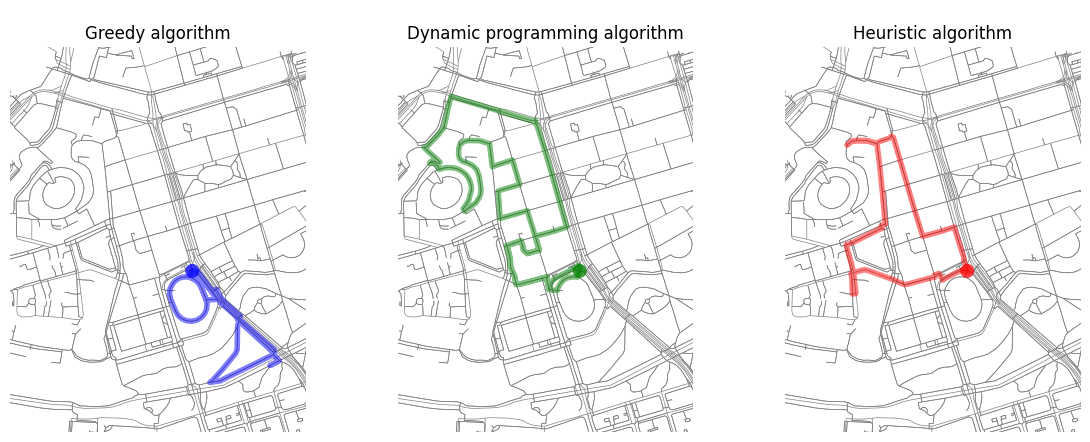

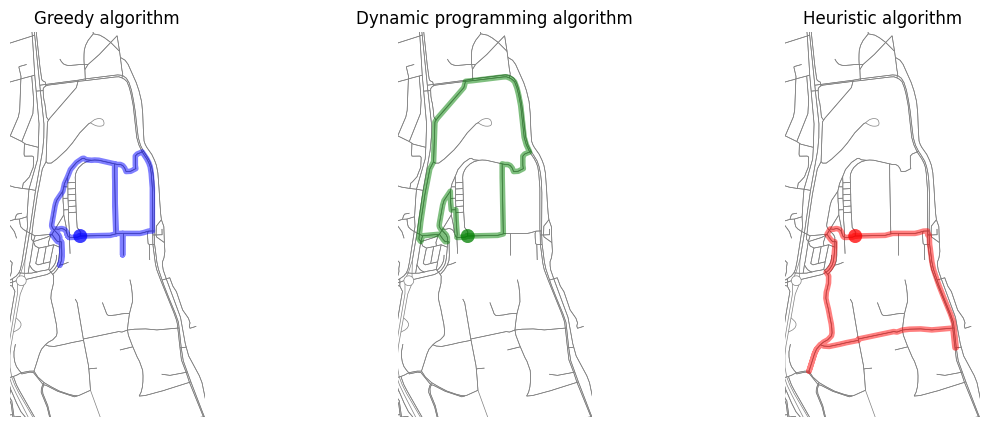

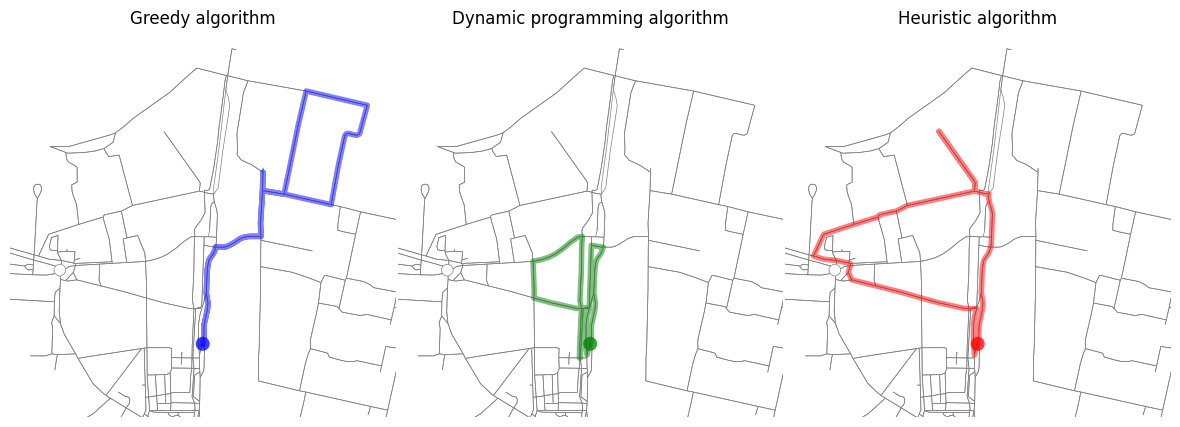

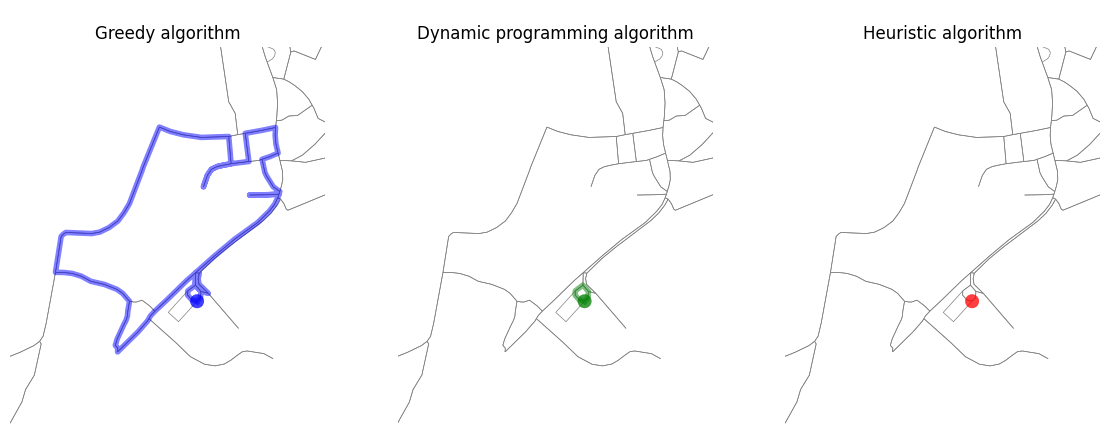

In [45]:
# Plot the routes for all algorithms 
def visualize_algorithms(lat, long, route_length, pref, dataset_num):
    G = prepare_graph(lat, long, route_length, pref, pref)
    
    start_vertex = ox.nearest_nodes(G, long, lat)
        
    greedy_route = greedy(G, start_vertex, route_length)
    dp_route = dp_approximation_scheme(G, start_vertex, route_length, pref, 100)
    heuristic_route = heuristic(G, start_vertex, route_length, pref)
    
    
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, wspace=0)  # Minimal horizontal space
    axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
    plt.subplots_adjust(wspace=0.0)
    
    # Create bounding box that fits all routes 
    G_greedy = G.subgraph(greedy_route)
    
    nodes_df_greedy = ox.graph_to_gdfs(G_greedy, edges=False)
    north_greedy, south_greedy = nodes_df_greedy['y'].max(), nodes_df_greedy['y'].min()
    east_greedy, west_greedy = nodes_df_greedy['x'].max(), nodes_df_greedy['x'].min()
    
    G_dp = G.subgraph(dp_route)
    
    nodes_df_dp = ox.graph_to_gdfs(G_dp, edges=False)
    north_dp, south_dp = nodes_df_dp['y'].max(), nodes_df_dp['y'].min()
    east_dp, west_dp = nodes_df_dp['x'].max(), nodes_df_dp['x'].min()
    
    G_heuristic = G.subgraph(heuristic_route)
    
    nodes_df_heuristic = ox.graph_to_gdfs(G_heuristic, edges=False)
    north_heuristic, south_heuristic = nodes_df_heuristic['y'].max(), nodes_df_heuristic['y'].min()
    east_heuristic, west_heuristic = nodes_df_heuristic['x'].max(), nodes_df_heuristic['x'].min()
    

    pad = 0.001
    north = max(north_greedy, north_dp, north_heuristic)
    south = min(south_greedy, south_dp, south_heuristic)
    east = max(east_greedy, east_dp, east_heuristic)
    west = min(west_greedy, west_dp, west_heuristic)
    bbox = (west-pad, south-pad, east+pad, north+pad)

    axs[0].set_title("Greedy algorithm")    
    ox.plot_graph(G=G, ax=axs[0], bbox=bbox, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False)
    ox.plot_graph_route(G=G,
                        bbox=bbox,
                        show=False,
                        close=False,
                        route=greedy_route,
                        route_color="blue",
                        route_linewidths=4,
                        ax=axs[0])

    axs[1].set_title("Dynamic programming algorithm")
    ox.plot_graph(G, ax=axs[1], bbox=bbox, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False)
    ox.plot_graph_route(G=G,
                        bbox=bbox,
                        show=False,
                        close=False,                       
                        route=dp_route,
                        route_color="green",
                        route_linewidths=4,
                        ax=axs[1])
    
    axs[2].set_title("Heuristic algorithm")
    ox.plot_graph(G, ax=axs[2], bbox=bbox, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False)
    ox.plot_graph_route(G=G,
                        bbox=bbox,
                        show=False,
                        close=False,                       
                        route=heuristic_route,
                        route_color="red",
                        route_linewidths=4,
                        ax=axs[2])
    
    axs[0].margins(0)
    axs[1].margins(0)
    axs[2].margins(0)
    
    filename = "plotalgs_" + str(dataset_num) + ".png"
    plt.savefig(filename, dpi=400, bbox_inches='tight')
    plt.show()
    
# Plot the routes of algorithms for all datasets    
pref = [0,0,0,0,0,0,0,0]
    
visualize_algorithms(dataset_1_lat, dataset_1_long, 1500, pref, 1)
visualize_algorithms(dataset_2_lat, dataset_2_long, 1500, pref, 2)
visualize_algorithms(dataset_3_lat, dataset_3_long, 1500, pref, 3)
visualize_algorithms(dataset_4_lat, dataset_4_long, 1500, pref, 4)

# Extra
Here are some extra code for a few things

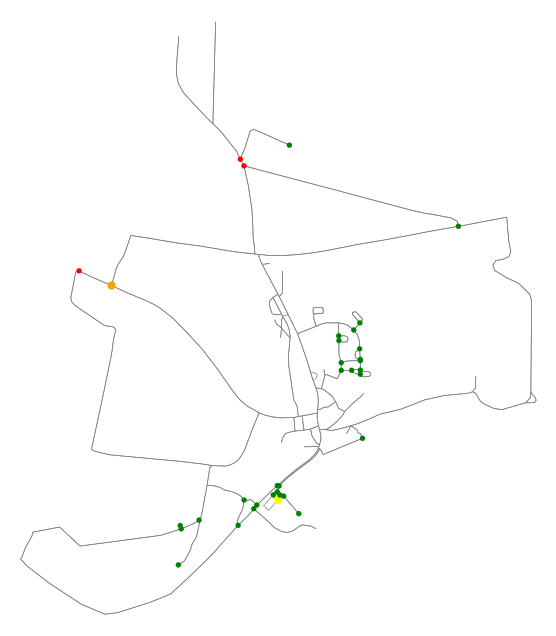

In [40]:
# Visualization of isochrones
def visualize_isochrone(lat, long, route_length):

    no_pref = [0,0,0,0,0,0,0,0]

    G = prepare_graph(lat, long, route_length, no_pref, no_pref)

    start_vertex = ox.nearest_nodes(G, long, lat)

    node_colors = {}
    node_sizes = {}
    
    node_colors[start_vertex] = "yellow"
    node_sizes[start_vertex] = 35

    # The isochrone includes all possible via-vertices
    isochrone = get_isochrone_nodes(G, start_vertex, route_length/3)

    for node in isochrone:
        node_colors[node] = "red"
        node_sizes[node] = 15
    
    # Choose a via-vertex in isochrone randomly
    via_vertex1 = random.sample(list(isochrone), 1)[0]
    node_colors[via_vertex1] = "orange"
    node_sizes[via_vertex1] = 35
    
    isochrone2 = get_isochrone_nodes(G, via_vertex1, route_length/3)

    possible_via_vertex2 = []

    for node in isochrone2:
        if node == start_vertex or node == via_vertex1:
            continue
        elif node in isochrone:
            possible_via_vertex2.append(node)
            node_colors[node] = "blue"
            node_sizes[node] = 15
        else:
            node_colors[node] = "green"
            node_sizes[node] = 15

    nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
    ns = [node_sizes[node] if node in node_sizes else 0 for node in G.nodes()]

    fig, ax = ox.plot.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.5, edge_color='gray', bgcolor="white", show=False, close=False)
    
    plt.savefig("visualize_isochrone.png", dpi=400, bbox_inches='tight')
    plt.show()
    
    
visualize_isochrone(dataset_4_lat, dataset_4_long, 3000)